In [1]:
import pickle

import pandas as pd
import numpy as np
import networkx as nx
from scipy.stats import beta
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import rankdata, kendalltau, spearmanr

import plotly.graph_objects as go
from tqdm.notebook import tqdm
from pathlib import Path

sns.set_theme("paper", "white")

In [2]:
df_users = pd.read_csv("./DSock/Active_Users.csv", index_col=0)
display(df_users.head())

timeline = pd.date_range("2020-09-03-03:59:59", periods=6, tz="utc")

,MTurk_ID,username,id,isMod,isObserver,isPuppet,n_reports,puppet,report,issued_posts,...,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Strategy
1,A10IUXCZBNYUXC,Jacob_1907,2658,f,f,f,17,0,1,25,...,2.0,2.0,2.0,1.0,1.0,2.0,1.0,4.0,2.0,NaN
2,A15F2JTVAJXITI,Luke_3376,2297,f,t,f,0,0,0,0,...,1.0,3.0,1.0,3.0,1.0,3.0,1.0,4.0,1.0,NaN
3,A173A97OFDAX9F,Claire_679,2601,f,f,f,0,0,0,4,...,1.0,2.0,2.0,1.0,1.0,2.0,1.0,3.0,3.0,NaN
4,A18XVBWB2A270I,Katherine_2323,2338,f,t,f,0,0,0,0,...,1.0,2.0,4.0,2.0,2.0,2.0,1.0,1.0,3.0,NaN
5,A1AIMKA54UBYIQ,Asia_4906,2638,f,f,f,1,0,1,9,...,3.0,3.0,2.0,1.0,2.0,2.0,2.0,4.0,3.0,NaN


In [3]:
topics = list("abcdefgh")
nums = list(range(9))
num2topic = dict(zip(nums, topics))
topic2num = dict(zip(topics, nums))
print(f"{topic2num} {num2topic}")
deltas = ["10", "21", "32", "43", "54"]

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7} {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h'}


In [4]:
df_evals = pd.read_csv("./DSock/human_eval_analysis/attitude_tracking.csv")
df_evals = pd.merge(df_users, df_evals, how="left", left_on="MTurk_ID", right_on="id").rename({"id_x": "id"}, axis=1)
df_evals.index = [f"u{u}" for u in df_evals["id"]]

display(df_evals.head())

get_change = lambda u, t: df_evals.loc[u][[f"{t}_delta_{d}" for d in deltas]].tolist()
print(get_change("u2337", num2topic[0]))

,MTurk_ID,username,id,isMod,isObserver,isPuppet,n_reports,puppet,report,issued_posts,...,g_delta_10,g_delta_21,g_delta_32,g_delta_43,g_delta_54,h_delta_10,h_delta_21,h_delta_32,h_delta_43,h_delta_54
u2658,A10IUXCZBNYUXC,Jacob_1907,2658,f,f,f,17,0,1,25,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
u2297,A15F2JTVAJXITI,Luke_3376,2297,f,t,f,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u2601,A173A97OFDAX9F,Claire_679,2601,f,f,f,0,0,0,4,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u2338,A18XVBWB2A270I,Katherine_2323,2338,f,t,f,0,0,0,0,...,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u2638,A1AIMKA54UBYIQ,Asia_4906,2638,f,f,f,1,0,1,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[3.0, 0.0, 0.0, 0.0, 0.0]


In [5]:
df_posts = pd.read_csv("./DSock/direct_influence/posts_with_senti_and_topic.csv", parse_dates=["createdAt"])
df_comts = pd.read_csv("./DSock/direct_influence/comments_with_senti_and_topic.csv", delimiter=",", parse_dates=["createdAt"]).dropna(subset=["CommenterId", "PostId"])
df_views = pd.read_csv("./DSock/postViews.csv", delimiter="|", parse_dates=["createdAt"]).dropna(subset=["UserId", "PostId"])
df_likes = pd.read_csv("./DSock/Likes.csv", delimiter="|", parse_dates=["createdAt"]).dropna(subset=["UserId", "PostId"])
df_repts = pd.read_csv("./DSock/ReportUsers.csv", delimiter="|", parse_dates=["createdAt"])

print(f"posts: {df_posts.shape}, comments: {df_comts.shape}, views: {df_views.shape}, likes: {df_likes.shape}, reports: {df_repts.shape}")

df_likes["UserId"] = df_likes["UserId"].astype(int)
df_likes["PostId"] = df_likes["PostId"].astype(int)

df_comts["CommenterId"] = df_comts["CommenterId"].astype(int)
df_comts["PostId"] = df_comts["PostId"].astype(int)

df_annot_posts = pd.read_csv("./DSock/posts_anno_labels.csv")
df_posts = df_posts.merge(df_annot_posts[["post_id", "majority_topic_label", "majority_sent_label"]], left_on="PostID", right_on="post_id")

df_annot_comts = pd.read_csv("./DSock/comments_anno_labels.csv")
df_comts = df_comts.merge(df_annot_comts[["comment_id", "majority_topic_label", "majority_sent_label"]], left_on="id", right_on="comment_id")

posts: (1057, 11), comments: (1615, 11), views: (234178, 10), likes: (1034, 6), reports: (46, 6)


In [6]:
post_comments = {f"p{p}": [] for p in df_posts["PostID"].values}
for c, p in df_comts[["id", "PostId"]].values:
    if f"p{p}" in post_comments:
        post_comments[f"p{p}"].append(f"c{c}")
G = nx.DiGraph()
for u, uname, obsr, sock in df_users[["id", "username", "isObserver", "isPuppet"]].values:
    G.add_node(f"u{u}", id=u, kind="user", name=uname, observer=(obsr == "t"), sock=(sock == "t"))
    if obsr == "t":
        G.nodes[f"u{u}"]["color"] = "obsr"
    elif sock == "t":
        G.nodes[f"u{u}"]["color"] = "sock"
    else:
        G.nodes[f"u{u}"]["color"] = "part"

for p, u, t, polar, score, topic in df_posts[["PostID", "AuthorId", "createdAt", "majority_sent_label", "scores", "majority_topic_label"]].values:
    if f"u{u}" in G.nodes:
        G.add_node(f"p{p}", id=p, kind="post", time=t, user=u, polar=polar, score=score, topic=topic)

for c, u, p, t, polar, score, topic in df_comts[["id", "CommenterId", "PostId", "createdAt", "majority_sent_label", "scores", "majority_topic_label"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes:
        G.add_node(f"c{c}", id=c, kind="comt", time=t, user=u, polar=polar, score=score, topic=topic)
        G.add_edge(f"c{c}", f"p{p}", kind="known", time=t, weight=1)
        # G.add_edge(f"p{p}", f"c{c}", kind="known", time=t, weight=1)

for l, u, p, t in df_likes[["id", "UserId", "PostId", "createdAt"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes:
        G.add_node(f"l{l}", user=f"u{u}", post=f"p{p}", time=t, id=l, kind="like",
                   topic=G.nodes[f"p{p}"]["topic"], polar=G.nodes[f"p{p}"]["polar"], score=1)
        G.add_edge(f"u{u}", f"l{l}", time=t, weight=1, kind="infer")
        G.add_edge(f"l{l}", f"p{p}", time=t, weight=1, kind="known")

for u, p, t, v, s in df_views[["UserId", "PostId", "createdAt", "id", "singleView"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes:
        G.add_node(f"v{v}", user=f"u{u}", post=f"p{p}", time=t, id=v, kind="view",
                   topic=G.nodes[f"p{p}"]["topic"], polar=G.nodes[f"p{p}"]["polar"], score=1)
        G.add_edge(f"u{u}", f"v{v}", time=t, weight=1, kind="infer")
        G.add_edge(f"v{v}", f"p{p}", time=t, weight=1, kind="infer")
        if s == "t":
            for c in post_comments[f"p{p}"]:
                if c in G.nodes:
                    G.add_edge(f"v{v}", c, time=t, weight=1, kind="infer")
user_view = {u: set() for u in G if u[0] == "u"}
for u, p, t, v, s in df_views[["UserId", "PostId", "createdAt", "id", "singleView"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes and s != "t":
        user_view[f"u{u}"].add(f"v{v}")

single_view = {u: set() for u in G if u[0] == "u"}
for u, p, t, v, s in df_views[["UserId", "PostId", "createdAt", "id", "singleView"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes and s == "t":
        single_view[f"u{u}"].add(f"v{v}")

print(f"user view: {sum([len(user_view[u]) for u in user_view])}")
print(f"single view: {sum([len(single_view[u]) for u in single_view])}")

for p in tqdm(G):
    if p[0] in ["p", "c"]:
        u = f"u{G.nodes[p]['user']}"
        for v in user_view[u] | single_view[u]:
            if G.nodes[v]["time"] <= G.nodes[p]["time"]:
                G.add_edge(p, v, time=G.nodes[v]["time"], weight=1, kind="infer")

user view: 210543
single view: 3808


In [7]:
with open("res/pagerank/0.85-0.5-0.5.pkl", "rb") as fp:
    d = pickle.load(fp)

In [8]:
df_users[df_users["id"] == 2340]

,MTurk_ID,username,id,isMod,isObserver,isPuppet,n_reports,puppet,report,issued_posts,...,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Strategy
7,A1CGW3DQ5JRSJH,Asia_3576,2340,f,t,f,0,0,0,0,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0,NaN


In [9]:
user_list = df_users["id"].tolist()
# user_list = df_users[df_users["isObserver"] == "f"]["id"].tolist()

In [10]:
obsr_list = [f"u{u}" for u in df_users[df_users["isObserver"] == "t"]["id"]]
pr_alpha = 0.85
beta_a = 0.5
beta_b = 0.5
keyq = [(node_name, t, topic, polar, pr_alpha, beta_a, beta_b)
        for node_name in obsr_list for t in range(1,6) for topic in range(8) for polar in [0, 2]
       ]

# keyq = list(filter(lambda x: get_change(x[0], num2topic[x[2]])[x[1]-1]*(1-x[3]) > 0, tqdm(keyq)))

In [11]:
property_full = {k: d[k]["full_graph"] for k in tqdm(keyq)}
property_exps = {k: d[k]["exps_graph"] for k in tqdm(keyq)}

df_full = pd.DataFrame.from_dict(property_full, orient="index")
df_exps = pd.DataFrame.from_dict(property_exps, orient="index")
df_exps["diameter"] = np.nan

In [12]:
use_color = sns.color_palette("Set1")
use_color

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

In [13]:
pd.DataFrame.from_dict({
    ("Full Influence Graph", "mean"): df_full.mean(axis=0),
    ("Full Influence Graph", "median"): df_full.median(axis=0),
    ("Full Influence Graph", "std"): df_full.std(axis=0),
    ("Expression only Influence Graph", "mean"): df_exps.mean(axis=0),
    ("Expression only Influence Graph", "median"): df_exps.median(axis=0),
    ("Expression only Influence Graph", "std"): df_exps.std(axis=0),
}).T

/home/rui/venvs/gcn/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


nodes        edges  components  \
Full Influence Graph            mean     615.178676  2076.139706    1.000000   
                                median     8.000000    10.000000    1.000000   
                                std     1737.033800  6639.101000    0.000000   
Expression only Influence Graph mean      17.275368     6.378676   10.896691   
                                median     3.000000     0.000000    3.000000   
                                std       33.123365    14.944595   18.640321   

                                         density  diameter    degree  
Full Influence Graph            mean    0.027653  3.119853  1.293062  
                                median  0.000899  3.000000  1.333333  
                                std     0.066253  3.140742  1.305748  
Expression only Influence Graph mean    0.005945       NaN  0.123662  
                                median  0.000000       NaN  0.000000  
                                std     0.013277       NaN  0.187201

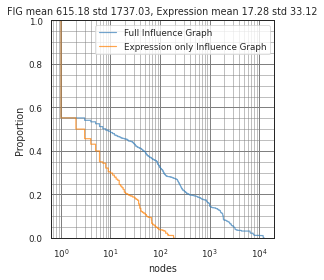

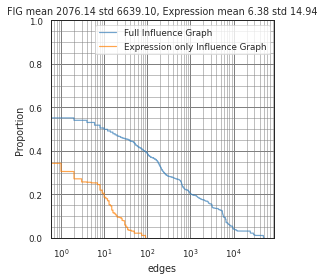

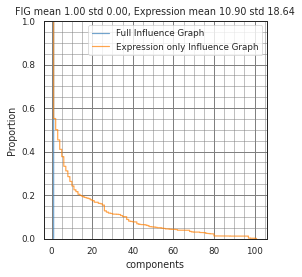

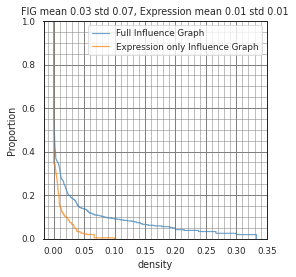

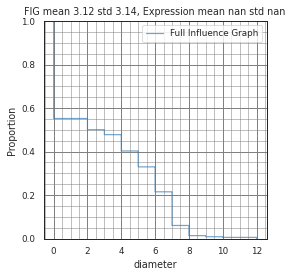

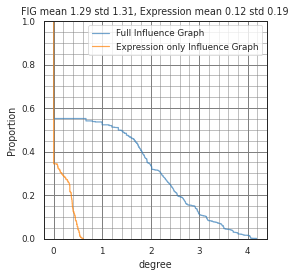

In [14]:
def plot_hist(name="nodes", xlabel="", ylabel="", title="", log_scale=False):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot()

    sns.ecdfplot(df_full[name], ax=ax, stat="proportion", label="Full Influence Graph", color=use_color[1], alpha=0.7, complementary=True, log_scale=log_scale)
    sns.ecdfplot(df_exps[name], ax=ax, stat="proportion", label="Expression only Influence Graph", color=use_color[4], alpha=0.7, complementary=True, log_scale=log_scale)

    ax.set_title(f"FIG mean {df_full[name].mean():.2f} std {df_full[name].std():.2f}, Expression mean {df_exps[name].mean():.2f} std {df_exps[name].std():.2f}")
    ax.set_xlabel(name)
    # ax.set_xscale("log")
    ax.legend()
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='grey', linewidth=1.0)
    ax.grid(b=True, which='minor', color='grey', linewidth=0.5)
    
    return fig, ax

# sns.set_theme("paper", "whitegrid")

fig, ax = plot_hist(name="nodes", log_scale=False)
ax.set_xscale("log")
# ax.set_xticks([1, 10, 100])

fig, ax = plot_hist(name="edges", log_scale=False)
ax.set_xscale("log")

fig, ax = plot_hist(name="components")
fig, ax = plot_hist(name="density")
fig, ax = plot_hist(name="diameter")
fig, ax = plot_hist(name="degree")